# Train Participant Classifiers

This script shows the process of training the participant classifiers.

In [1]:
%matplotlib inline

import sys

sys.path.append(".")
sys.path.append("..")

import json

import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

In [2]:
from tactics2d.participant.element import Pedestrian, Cyclist, Vehicle
from tactics2d.trajectory.element import Trajectory
from tactics2d.trajectory.parser import LevelXParser, InteractionParser, DLPParser

## Classify by trajectory

In [3]:
def get_feature(trajectory: Trajectory):
    history_speed = [state.speed for state in trajectory.history_states.values()]
    speed_mean = np.mean(history_speed)
    speed_std = np.std(history_speed)
    speed_max = np.max(history_speed)

    X = np.array([speed_mean, speed_std, speed_max])
    return X

In [4]:
def get_data(participants):
    X_list = []
    y_list = []
    for participant in participants.values():
        if isinstance(participant, Pedestrian):
            X_list.append(get_feature(participant.trajectory))
            y_list.append(0)
        elif isinstance(participant, Cyclist) and participant.type_ == "bicycle":
            X_list.append(get_feature(participant.trajectory))
            y_list.append(1)
    return X_list, y_list

In [5]:
trajectory_clf = svm.SVC(kernel="rbf", C=0.1, gamma=0.25)

In [6]:
trajectory_path = "../tactics2d/data/trajectory_raw/DLP/"

trajectory_parser = DLPParser()

X_list, y_list = [], []

for i in range(1, 31):
    participants = trajectory_parser.parse(i, trajectory_path)
    X, y = get_data(participants)
    X_list += X
    y_list += y

print(
    "In total there are %d samples. %d are pedestrians and %d are cyclists." 
    % (len(X_list), np.sum(np.array(y_list)==0), np.sum(np.array(y_list)==1))
)

X_train, X_test, y_train, y_test = train_test_split(X_list, y_list, test_size=0.25)
trajectory_clf.fit(X_train, y_train)
y_test_predict = trajectory_clf.predict(X_test)

correct = np.sum(y_test_predict == y_test)
print("Precision: ", correct / len(y_test))

In total there are 3938 samples. 3910 are pedestrians and 28 are cyclists.
Precision:  0.9949238578680203


The precision of the classifier is low mainly because the data sample is too small. Therefore, we move to InD and RounD dataset to train the trajectory classifier.

In [7]:
trajectory_clf_inD = svm.SVC(kernel="rbf", C=0.1, gamma=0.25)

In [8]:
with open("../tactics2d/data/map_default.config", "r") as f_config:
    map_configs = json.load(f_config)

In [9]:
trajectory_path_inD = "../tactics2d/data/trajectory_raw/inD"

trajectory_parser_inD = LevelXParser("inD")

X_list_inD, y_list_inD = [], []

for map_config in map_configs.values():
    if "inD" not in map_config["map_name"]:
        continue

    for file_id in map_config["track_files"]:
        participants = trajectory_parser_inD.parse(file_id, trajectory_path_inD)
        
        X, y = get_data(participants)
        X_list_inD += X
        y_list_inD += y

print(
    "In total there are %d samples. %d are pedestrians and %d are cyclists." 
    % (len(X_list_inD), np.sum(np.array(y_list_inD)==0), np.sum(np.array(y_list_inD)==1))
)

X_train_inD, X_test_inD, y_train_inD, y_test_inD = train_test_split(X_list_inD, y_list_inD, test_size=0.25)
trajectory_clf_inD.fit(X_train_inD, y_train_inD)

In total there are 5366 samples. 3107 are pedestrians and 2259 are cyclists.


SVC(C=0.1, gamma=0.25)

In [10]:
y_train_predict_inD = trajectory_clf_inD.predict(X_train_inD)
correct_inD = np.sum(y_train_predict_inD == y_train_inD)
print("Train set precision: ", correct_inD / len(y_train_inD))

y_test_predict_inD = trajectory_clf_inD.predict(X_test_inD)
correct_inD = np.sum(y_test_predict_inD == y_test_inD)
print("Test set precision: ", correct_inD / len(y_test_inD))

Train set precision:  0.9659542743538767
Test set precision:  0.9672131147540983


In [11]:
def visualize_clusters(X_list, y_list):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(X_list[:, 0], X_list[:,1], X_list[:,2], c=y_list)
    ax.set_xlabel("v_mean")
    ax.set_ylabel("v_std")
    ax.set_zlabel("v_max")

    plt.show()

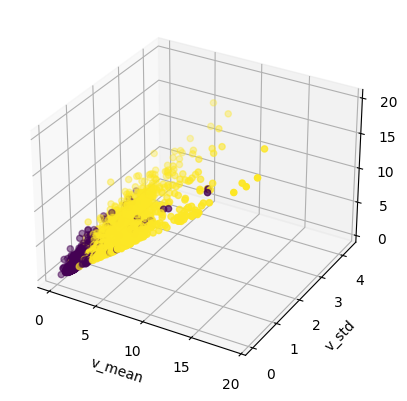

In [12]:
visualize_clusters(np.array(X_train_inD), y_train_inD)

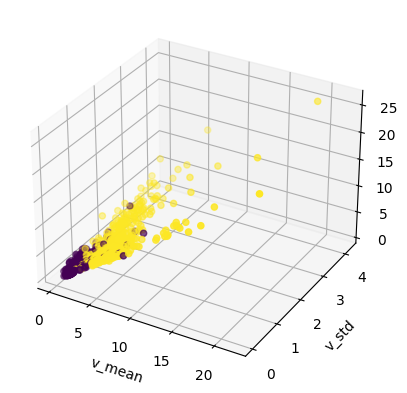

In [13]:
visualize_clusters(np.array(X_test_inD), y_test_inD)

In [14]:
trajectory_clf_rounD = svm.SVC(kernel="rbf", C=0.1, gamma=0.25)

In [15]:
trajectory_path_rounD = "../tactics2d/data/trajectory_raw/rounD"

trajectory_parser_rounD = LevelXParser("rounD")

X_list_rounD, y_list_rounD = [], []

for map_config in map_configs.values():
    if "rounD" not in map_config["map_name"]:
        continue

    for file_id in map_config["track_files"]:
        participants = trajectory_parser_inD.parse(file_id, trajectory_path_rounD)
        
        X, y = get_data(participants)
        X_list_rounD += X
        y_list_rounD += y

print(
    "In total %d samples. %d are pedestrians and %d are cyclists." 
    % (len(X_list_rounD), np.sum(np.array(y_list_rounD)==0), np.sum(np.array(y_list_rounD)==1))
)

X_train_rounD, X_test_rounD, y_train_rounD, y_test_rounD = train_test_split(X_list_rounD, y_list_rounD, test_size=0.25)
trajectory_clf_rounD.fit(X_train_rounD, y_train_rounD)

In total 113 samples. 25 are pedestrians and 88 are cyclists.


SVC(C=0.1, gamma=0.25)

In [16]:
y_train_predict_rounD = trajectory_clf_rounD.predict(X_train_rounD)
correct_rounD = np.sum(y_train_predict_rounD == y_train_rounD)
print("Train set precision: ", correct_rounD / len(y_train_rounD))

y_test_predict_rounD = trajectory_clf_rounD.predict(X_test_rounD)
correct_rounD = np.sum(y_test_predict_rounD == y_test_rounD)
print("Test set precision: ", correct_rounD / len(y_test_rounD))

Train set precision:  0.9880952380952381
Test set precision:  0.9655172413793104


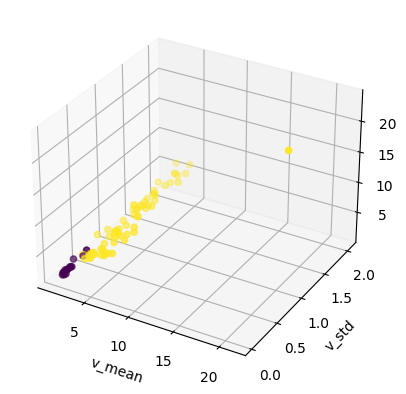

In [17]:
visualize_clusters(np.array(X_train_rounD), y_train_rounD)

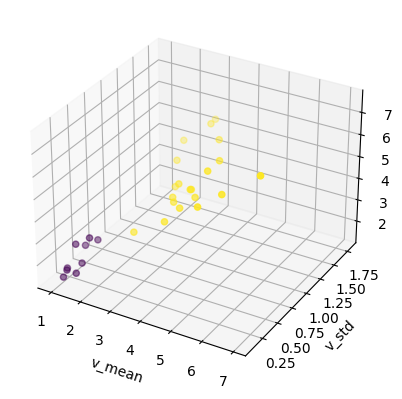

In [18]:
visualize_clusters(np.array(X_test_rounD), y_test_rounD)

Then we cross evaluate the inD and rounD based classifiers.

In [19]:
y_predict_rounD = trajectory_clf_inD.predict(X_list_rounD)
correct_rounD = np.sum(y_predict_rounD == y_list_rounD)
print("Train set precision: ", correct_rounD / len(y_list_rounD))

Train set precision:  0.9646017699115044


In [20]:
y_predict_inD = trajectory_clf_rounD.predict(X_list_inD)
correct_inD = np.sum(y_predict_inD == y_list_inD)
print("Train set precision: ", correct_inD / len(y_list_inD))

Train set precision:  0.9562057398434588


In [21]:
trajectory_clf_levelx = svm.SVC(kernel="rbf", C=0.1, gamma=0.25)

In [22]:
trajectory_clf_levelx.fit(X_train_inD+X_train_rounD, y_train_inD+y_train_rounD)

SVC(C=0.1, gamma=0.25)

In [23]:
y_train_predict_inD = trajectory_clf_levelx.predict(X_train_inD)
correct_inD = np.sum(y_train_predict_inD == y_train_inD)
print("InD train set precision: ", correct_inD / len(y_train_inD))

y_test_predict_inD = trajectory_clf_levelx.predict(X_test_inD)
correct_inD = np.sum(y_test_predict_inD == y_test_inD)
print("InD test set precision: ", correct_inD / len(y_test_inD))

y_train_predict_rounD = trajectory_clf_levelx.predict(X_train_rounD)
correct_rounD = np.sum(y_train_predict_rounD == y_train_rounD)
print("RounD train set precision: ", correct_rounD / len(y_train_rounD))

y_test_predict_rounD = trajectory_clf_levelx.predict(X_test_rounD)
correct_rounD = np.sum(y_test_predict_rounD == y_test_rounD)
print("RounD test set precision: ", correct_rounD / len(y_test_rounD))

InD train set precision:  0.9664512922465208
InD test set precision:  0.9679582712369598
RounD train set precision:  0.9642857142857143
RounD test set precision:  1.0


The classifier trained in the levelX dataset can be applied to the DLP dataset.

In [24]:
y_predict_dlp = trajectory_clf_levelx.predict(X_list)
correct = np.sum(y_predict_dlp == y_list)
print("Precision", correct / len(y_list))

Precision 0.989588623666836


In [25]:
joblib.dump(trajectory_clf_levelx, "trajectory_classifier.m")

['trajectory_classifier.m']